# Imports

In [1]:

import torch
import torchvision
from torchvision import transforms, models


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

from datetime import datetime

# Helpers
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ML
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


# Data

## Labels

In [2]:
# Open metadata.json file
import json
with open('./data/metadata.json') as f:
    metadata = json.load(f)


In [3]:
# Convert the metadata to a pandas DataFrame
metadata_df = pd.DataFrame(metadata)

# Transpose the DataFrame
metadata_df = metadata_df.transpose()

# Reset the index
metadata_df.reset_index(inplace=True)

# Rename the column index to filename
metadata_df.rename(columns={'index': 'filename'}, inplace=True)

# Convert labels to integers.
# REAL = 0
# FAKE = 1
metadata_df['label'] = metadata_df['label'].map({'REAL': 0, 'FAKE': 1})

In [4]:
metadata_df

,filename,label,split,original
0,owxbbpjpch.mp4,1,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,0,train,NaN
2,fzvpbrzssi.mp4,0,train,NaN
3,htorvhbcae.mp4,1,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,1,train,vpmyeepbep.mp4
...,...,...,...,...
1329,hectzcuzdv.mp4,1,train,vtunvalyji.mp4
1330,yxkbjxmtzr.mp4,1,train,sttnfyptum.mp4
1331,wkdnagybtb.mp4,1,train,jytrvwlewz.mp4
1332,fonrexmbzz.mp4,1,train,fufcmupzen.mp4


## Dataset creation

In [5]:
def extract_frames(video_path, num_frames=16):
    """Extract `num_frames` evenly spaced frames from a video."""
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_idxs = list(np.linspace(0, length-1, num_frames).astype(int))
    frames = []
    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames

In [6]:

class DeepfakeDataset(Dataset):
    def __init__(self, video_dir, labels_df, transform=None, num_frames=16):
        self.video_dir = video_dir
        
        # Remove all the labels that are not in the video_dir
        labels_df = labels_df[labels_df['filename'].isin(os.listdir(video_dir))]
        
        self.labels = labels_df
        self.transform = transform
        self.num_frames = num_frames

    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        video_file = self.labels.iloc[idx]['filename']
        label = self.labels.iloc[idx]['label']  # 0: real, 1: fake
        video_path = os.path.join(self.video_dir, video_file)
        frames = extract_frames(video_path, num_frames=self.num_frames)
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        # stack to (num_frames, C, H, W)
        frames = torch.stack(frames)
        return frames, torch.tensor(label, dtype=torch.long)


In [7]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets for training & validation, download if necessary
training_set = DeepfakeDataset('./data/train_sub', metadata_df, transform=data_transforms)
validation_set = DeepfakeDataset('./data/val_sub', metadata_df, transform=data_transforms)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('FAKE', 'REAL')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 7 instances
Validation set has 2 instances


# Visualization

In [8]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [9]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

REAL  REAL  REAL  REAL


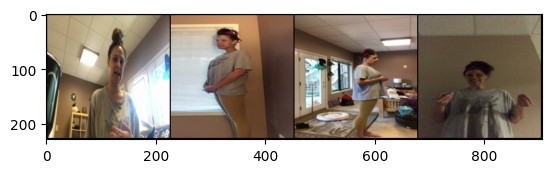

In [10]:
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid([images[0][0], images[1][0], images[2][0], images[3][0]], nrow=4)
matplotlib_imshow(img_grid)
print('  '.join(classes[labels[j]] for j in range(4)))

# Model

In [11]:
class VideoCNN(nn.Module):
    def __init__(self, weights="ResNet18_Weights.DEFAULT"):
        super(VideoCNN, self).__init__()
        self.backbone = models.resnet18(weights=weights)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 2)

    def forward(self, x):
        # x shape: (B, num_frames, C, H, W)
        B, F, C, H, W = x.size()
        x = x.view(B * F, C, H, W)
        feats = self.backbone(x)
        feats = feats.view(B, F, -1).mean(1)  # average pooling over frames
        return feats

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print ("Using device:", device)
model = VideoCNN()

# Multi-GPU support
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
    
model = model.to(device)

Using device: mps


# Loss function

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer

In [13]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop

In [14]:
# Function to train the model for one epoch
def train_epoch(model, loader, criterion, optimizer, writer, epoch):
    """
    Train the model for one epoch.

    Args:
        model: The model to train.
        loader: DataLoader for the training data.
        criterion: Loss function.
        optimizer: Optimizer for updating model weights.
        writer: TensorBoard SummaryWriter for logging.
        epoch: Current epoch number.

    Returns:
        epoch_loss: Average loss for the epoch.
        epoch_acc: Accuracy for the epoch.
    """
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc=f"Training Epoch {epoch+1}"):
        # Move inputs and labels to the device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_acc, epoch)

    return epoch_loss, epoch_acc

# Function to evaluate the model for one epoch
def eval_epoch(model, loader, criterion, writer, epoch):
    """
    Evaluate the model for one epoch.

    Args:
        model: The model to evaluate.
        loader: DataLoader for the validation data.
        criterion: Loss function.
        writer: TensorBoard SummaryWriter for logging.
        epoch: Current epoch number.

    Returns:
        epoch_loss: Average loss for the epoch.
        epoch_acc: Accuracy for the epoch.
    """
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in tqdm(loader, desc=f"Validation Epoch {epoch+1}"):
            # Move inputs and labels to the device (GPU/CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Accumulate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Calculate average loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Log validation loss and accuracy to TensorBoard
    writer.add_scalar('Validation Loss', epoch_loss, epoch)
    writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

    return epoch_loss, epoch_acc


# Per-epoch activity

In [15]:
BEST_MODEL_PATH = './best_model.pth'
LAST_MODEL_PATH = './last_model.pth'

# Check if the model already exists
if os.path.exists(BEST_MODEL_PATH):
    # Ask the user if they want to overwrite the existing model
    user_input = input(f"Model already exists at {BEST_MODEL_PATH}. Do you want to overwrite it? (y/n): ")
    if user_input.lower() == 'y':
        pass
    else:
        raise ValueError(f"Model already exists at {BEST_MODEL_PATH}. Please remove it before training.")

In [16]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/deepfake_logs_{}'.format(timestamp))
epoch_number = 0

num_epochs = 10
best_acc = 0.0
patience = 3  # Number of epochs to wait for improvement
no_improve_epochs = 0  # Counter for epochs without improvement

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, training_loader, loss_fn, optimizer, writer, epoch)
    val_loss, val_acc = eval_epoch(model, validation_loader, loss_fn, writer, epoch)
    print(f"Epoch {epoch+1}/{num_epochs}", 
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}", 
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        no_improve_epochs = 0  # Reset counter if validation accuracy improves
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    # Save the model last epoch
    torch.save(model.state_dict(), LAST_MODEL_PATH)

Validation Epoch 1: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


Epoch 1/10 Train Loss: 0.6981, Train Acc: 0.7143 Val Loss: 0.3529, Val Acc: 1.0000


Validation Epoch 2: 100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


Epoch 2/10 Train Loss: 0.2282, Train Acc: 1.0000 Val Loss: 0.0935, Val Acc: 1.0000


Validation Epoch 3: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Epoch 3/10 Train Loss: 0.0410, Train Acc: 1.0000 Val Loss: 0.0236, Val Acc: 1.0000


Validation Epoch 4: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

Epoch 4/10 Train Loss: 0.0082, Train Acc: 1.0000 Val Loss: 0.0070, Val Acc: 1.0000
Early stopping triggered after 4 epochs.


# Open saved model

In [17]:
saved_model = VideoCNN()
saved_model.load_state_dict(torch.load(BEST_MODEL_PATH))

<All keys matched successfully>

# Inference

In [18]:
# Example inference on a single video
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

video_path = 'data/val/acagallncj.mp4'
frames = extract_frames(video_path, num_frames=16)
inputs = data_transforms(frames[0]).unsqueeze(0)  # For demonstration, use first frame
inputs = inputs.to(device)
with torch.no_grad():
    output = model(inputs.unsqueeze(1))  # shape (1, num_frames, C, H, W)
    pred = output.argmax(dim=1).item()
print("Predicted label: ", 'Fake' if pred == 1 else 'Real')
print("Real label: ", 'Fake' if metadata_df[metadata_df['filename'] == 'acagallncj.mp4']['label'].values[0]== 1 else 'Real')

Predicted label:  Fake
Real label:  Fake


# Test

Testing: 100%|██████████| 1/1 [00:02<00:00,  2.12s/it]

Test Accuracy : 1.0000
Precision     : 1.0000
Recall        : 1.0000
F1 Score      : 1.0000

Classification Report:
               precision    recall  f1-score   support

        FAKE       0.00      0.00      0.00         0
        REAL       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0




/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/robertogiordano/anaconda3/envs/deepfake_det/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  

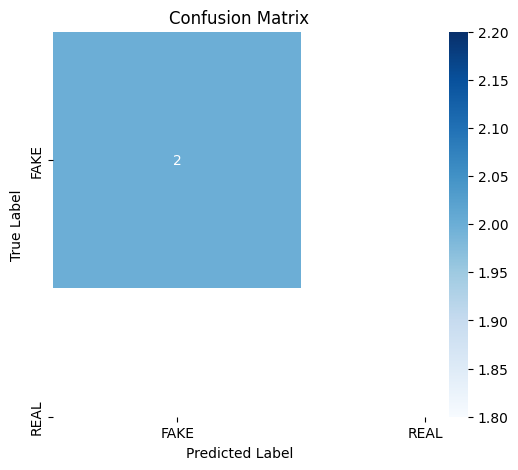

In [20]:

# Run test loop on validation set
model.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in tqdm(validation_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Compute metrics
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary')
rec  = recall_score(all_labels, all_preds, average='binary')
f1   = f1_score(all_labels, all_preds, average='binary')

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {prec:.4f}")
print(f"Recall        : {rec:.4f}")
print(f"F1 Score      : {f1:.4f}\n")
print("Classification Report:\n", 
      classification_report(all_labels, all_preds, labels=classes, target_names=classes))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()